In [ ]:
# Web Application Attack Detection using KNN

## Author: Shalev Mazuz
## Description: This notebook implements a KNN classifier to detect web application attacks.

In [2]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

# Other
import warnings
warnings.filterwarnings('ignore')
from collections import Counter


In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Shalev Mazuz- Final report/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX-CSV.csv")

# Quick overview
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170366 entries, 0 to 170365
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             170366 non-null  int64  
 1    Flow Duration                170366 non-null  int64  
 2    Total Fwd Packets            170366 non-null  int64  
 3    Total Backward Packets       170366 non-null  int64  
 4   Total Length of Fwd Packets   170366 non-null  int64  
 5    Total Length of Bwd Packets  170366 non-null  int64  
 6    Fwd Packet Length Max        170366 non-null  int64  
 7    Fwd Packet Length Min        170366 non-null  int64  
 8    Fwd Packet Length Mean       170366 non-null  float64
 9    Fwd Packet Length Std        170366 non-null  float64
 10  Bwd Packet Length Max         170366 non-null  int64  
 11   Bwd Packet Length Min        170366 non-null  int64  
 12   Bwd Packet Length Mean       170366 non-nul

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,170366.000000,1.703660e+05,170366.000000,170366.000000,1.703660e+05,1.703660e+05,170366.000000,170366.000000,170366.000000,170366.000000,...,170366.000000,170366.000000,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05,1.703660e+05
mean,7897.090599,1.246354e+07,15.124620,18.022276,5.569859e+02,3.183147e+04,167.775982,22.697786,48.233250,47.235628,...,11.925108,25.584506,7.433804e+04,4.676038e+04,1.646422e+05,5.012699e+04,3.690478e+06,1.310724e+05,3.784764e+06,3.543232e+06
std,18235.489428,3.193852e+07,1123.107756,1494.492871,7.710431e+03,3.460816e+06,461.299214,37.990783,94.947821,141.927429,...,1077.898793,6.354041,6.182048e+05,3.689605e+05,9.958673e+05,5.606797e+05,1.298830e+07,1.733767e+06,1.325135e+07,1.284183e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,1.920000e+02,1.000000,1.000000,3.100000e+01,6.000000e+00,23.000000,0.000000,7.882314,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,3.141200e+04,2.000000,2.000000,6.800000e+01,1.340000e+02,41.000000,6.000000,38.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,8.169818e+05,4.000000,2.000000,1.480000e+02,3.280000e+02,60.000000,41.000000,50.000000,17.897858,...,3.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65529.000000,1.200000e+08,200755.000000,270686.000000,1.197199e+06,6.270000e+08,23360.000000,1729.000000,4183.057143,5463.493850,...,192491.000000,60.000000,1.030000e+08,6.370000e+07,1.030000e+08,1.030000e+08,1.200000e+08,7.260000e+07,1.200000e+08,1.200000e+08


In [ ]:
# Alter to binary class
df.columns = df.columns.str.strip()
df['Label'] = df['Label'].apply(lambda x: 'BENIGN' if x.strip().upper() == 'BENIGN' else 'ATTACK')

# Remove problemtaic rows
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Separate features and target
X = df.drop("Label", axis=1)
y = df["Label"]

# Encode categorical features
le = LabelEncoder()
y = le.fit_transform(df['Label'])

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = X.columns[selector.get_support()]
X = pd.DataFrame(X_selected, columns=selected_features)

# Check for class imbalance
print("Class distribution:", Counter(y))


Class distribution: Counter({np.int64(1): 168051, np.int64(0): 2180})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

Accuracy: 0.9997062883660822

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       436
           1       1.00      1.00      1.00     33611

    accuracy                           1.00     34047
   macro avg       0.99      1.00      0.99     34047
weighted avg       1.00      1.00      1.00     34047


Confusion Matrix:


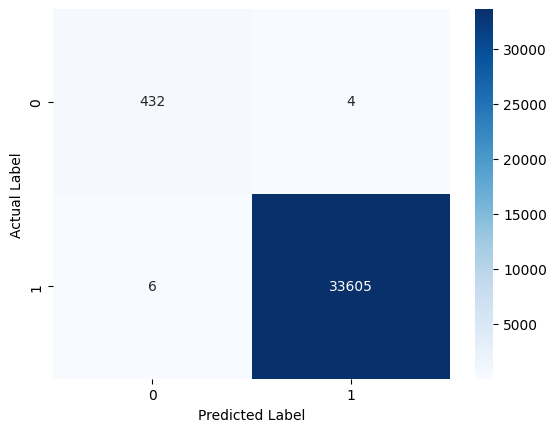

In [ ]:
# Model evaluation
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

**All of the following code is for analysis purposes**

  0%|          | 0/100 [00:00<?, ?it/s]

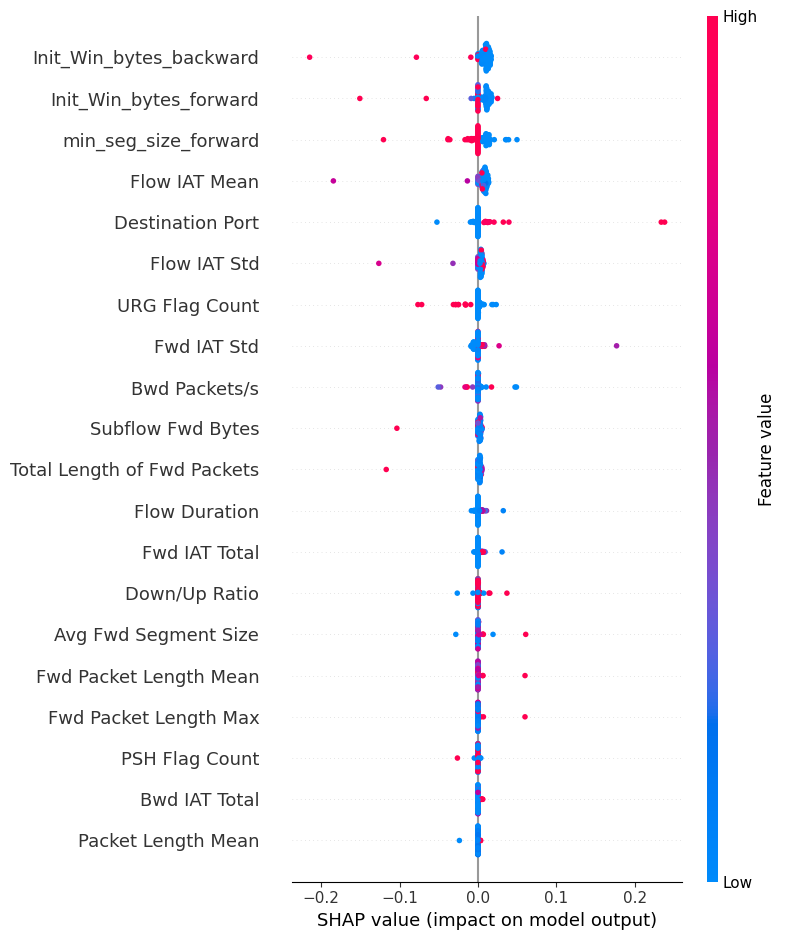

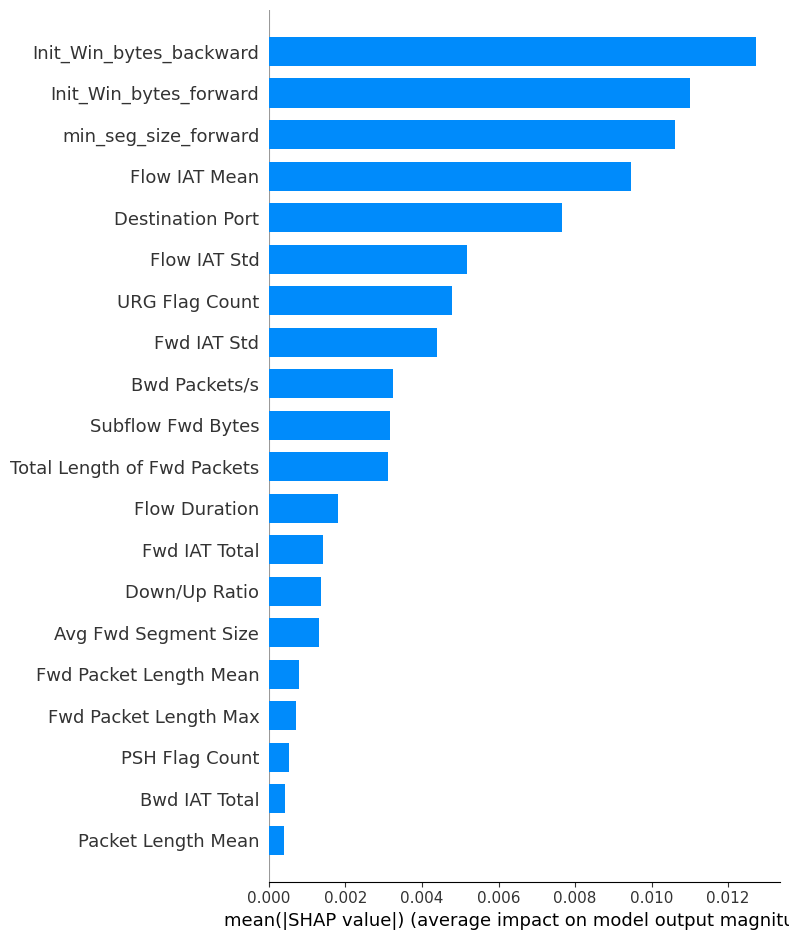

In [ ]:
import shap
import numpy as np

explainer = shap.KernelExplainer(knn.predict, shap.sample(X_train, 100, random_state=42))

# Compute SHAP values for a sample of test data (to keep it fast)
shap_values = explainer.shap_values(shap.sample(X_test, 100, random_state=42))

# Summary plot (global feature importance)
shap.summary_plot(shap_values, shap.sample(X_test, 100, random_state=42), feature_names=X.columns)

# Bar plot (average absolute SHAP values per feature)
shap.summary_plot(shap_values, shap.sample(X_test, 100, random_state=42), feature_names=X.columns, plot_type="bar")


    accuracy  precision    recall        f1
1   0.999677   0.999680  0.999677  0.999678
3   0.999706   0.999707  0.999706  0.999707
5   0.999589   0.999591  0.999589  0.999590
7   0.999530   0.999534  0.999530  0.999532
9   0.999471   0.999478  0.999471  0.999474
11  0.999324   0.999337  0.999324  0.999329
15  0.999119   0.999147  0.999119  0.999128


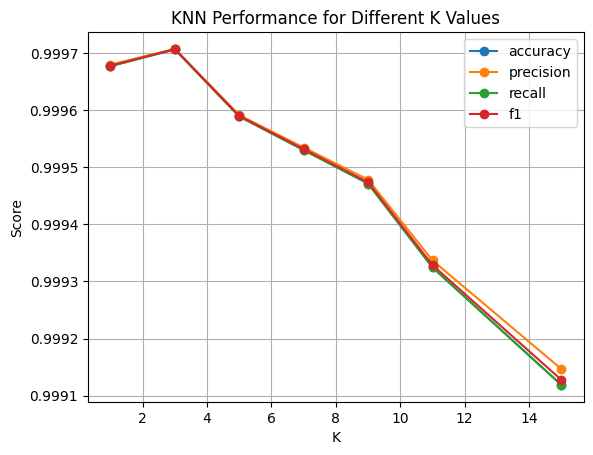

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
k_values = [1, 3, 5, 7, 9, 11, 15]
results = {}
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    results[k] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
results_df = pd.DataFrame(results).T
print(results_df)

results_df.plot(kind='line', marker='o')
plt.title('KNN Performance for Different K Values')
plt.xlabel('K')
plt.ylabel('Score')
plt.grid(True)
plt.show()

           accuracy  precision    recall        f1
euclidean  0.999706   0.999707  0.999706  0.999707
manhattan  0.999736   0.999737  0.999736  0.999736
chebyshev  0.999589   0.999590  0.999589  0.999589
minkowski  0.999706   0.999707  0.999706  0.999707


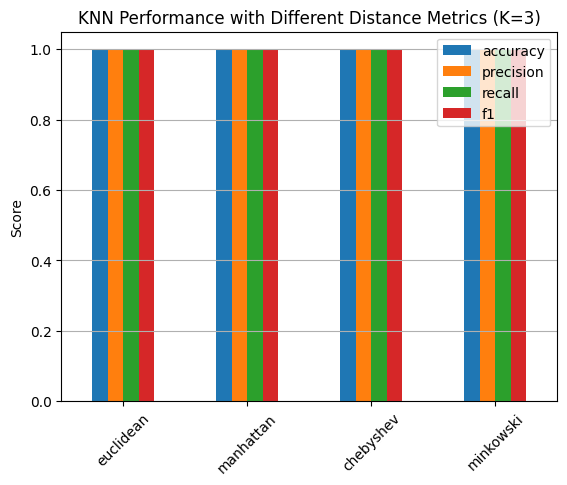

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]
results = {}

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=3, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    results[metric] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1": f1_score(y_test, y_pred, average="weighted")
    }

results_df = pd.DataFrame(results).T
print(results_df)

results_df.plot(kind="bar")
plt.title("KNN Performance with Different Distance Metrics (K=3)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()


In [ ]:
import numpy as np

# get predictions
y_pred = knn.predict(X_test)

# find indices of FP and FN
fp_indices = np.where((y_pred == 0) & (y_test == 1))[0]
fn_indices = np.where((y_pred == 1) & (y_test == 0))[0]

print("False Positive examples:", fp_indices)
print("False Negative examples:", fn_indices)

# pick one FP and one FN
fp_idx = fp_indices[0]
fn_idx = fn_indices[0]

print("False Positive sample:\n", X_test.iloc[fp_idx])
print("True label:", y_test[fp_idx], "Predicted:", y_pred[fp_idx])

print("\nFalse Negative sample:\n", X_test.iloc[fn_idx])
print("True label:", y_test[fn_idx], "Predicted:", y_pred[fn_idx])

print("\nlog 10359: \n", X_test.iloc[10359])
print("\nlog 2627: \n", X_test.iloc[2627])

False Positive examples: [10359 19549 21062 25810 26523 31441]
False Negative examples: [ 6941 20000 25029 28616]
False Positive sample:
 Destination Port              -0.428196
Flow Duration                 -0.205535
Total Length of Fwd Packets   -0.072266
Fwd Packet Length Max         -0.363850
Fwd Packet Length Min         -0.597640
Fwd Packet Length Mean        -0.508179
Fwd Packet Length Std         -0.332946
Bwd Packet Length Max         -0.494467
Bwd Packet Length Min         -0.732137
Bwd Packet Length Mean        -0.583803
Bwd Packet Length Std         -0.447228
Flow Packets/s                -0.240777
Flow IAT Mean                  0.241699
Flow IAT Std                   0.305186
Fwd IAT Total                 -0.197644
Fwd IAT Std                    0.776473
Fwd IAT Min                   -0.129353
Bwd IAT Total                 -0.364409
Bwd IAT Mean                  -0.196192
Bwd IAT Std                   -0.251586
Bwd IAT Max                   -0.275061
Bwd IAT Min           